In [1]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame

from os import path
import session_info
import logging
from tempfile import TemporaryDirectory 
from os import system
import celltypist
from celltypist import models as ctypist_models


logging.basicConfig(level=logging.ERROR)

sc.set_figure_params(figsize=(6, 6), frameon=False)


In [ ]:
# Add CELL_TYPIST model(s) to use 
CELL_TYPIST_MODELS: list[str] = []

In [ ]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [ ]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]

In [64]:
# def scvi_cellassign_annotate(adata: AnnData, marker_matrix: DataFrame, subsample: int = 2000):

#     import torch
#     from scvi.external import CellAssign

#     torch.set_float32_matmul_precision("high")

#     markers_common = list(set(adata.var_names).intersection(set(marker_matrix.index)))
#     adata_annotate = sc.pp.subsample(adata, n_obs = subsample, copy = True)
    
#     adata_annotate = adata_annotate[:, list(markers_common)].copy()

#     adata_annotate.X = adata_annotate.layers[COUNTS_LAYER]
#     lib_size = adata_annotate.layers[COUNTS_LAYER].sum(1)
#     adata_annotate.obs["size_factor"] = lib_size / np.mean(lib_size)

#     scvi.external.CellAssign.setup_anndata(adata_annotate, size_factor_key="size_factor")
#     cellassign_model = CellAssign(adata_annotate, marker_matrix)

#     return cellassign_model, adata_annotate


# def convert_scHCA(tissue: str, quantile: float = 0.98):
#     df = pd.read_csv("../resources/scHCL_DB.csv", index_col=0)
#     tissue_df = df.filter(regex=tissue)
#     quantiles = tissue_df.quantile(q=quantile, axis=0)
#     binary_markers = tissue_df.gt(quantiles, axis=1).astype("int")
    
#     # Remove markers where it is all 0 or 1
#     binary_markers = binary_markers.loc[~(binary_markers == 0).all(axis=1)]
#     binary_markers = binary_markers.loc[~(binary_markers == 1).all(axis=1)]

#     return binary_markers


def cell_typist_annotate(adata: AnnData, models: list[str], inplace = True):
    import celltypist
    from celltypist import models as ctypist_models

    if len(models) == 0:
        raise ValueError("The models list are empty, enter valid model names.")

    all_models = ctypist_models.models_description().model.to_list()

    for model in models:
        if model not in all_models:
            raise ValueError("{model} not found in supported cell typist models.")


    ctypist_models.download_models(force_update=True, model=models)

    adata_celltypist = adata.copy()  
    adata_celltypist.X = adata.layers[COUNTS_LAYER]  
    sc.pp.normalize_per_cell(adata_celltypist, counts_per_cell_after=10**4)  
    sc.pp.log1p(adata_celltypist)
    adata_celltypist.X = adata_celltypist.X.toarray()

    for model in models:
        loaded_model = ctypist_models.Model.load(model = model)
        predictions = celltypist.annotate(adata_celltypist, model=loaded_model, majority_voting=True)
        predictions_adata = predictions.to_adata()
        adata.obs["celltypist_"+model+"_label"] = predictions_adata.obs.loc[adata.obs.index, "majority_voting"]
        adata.obs["celltypist_"+model+"_conf_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    if not inplace:
        return adata


def annotate_scGPT(adata: AnnData):
    pass



In [29]:
## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [30]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
TISSUE = config["basic"]["TISSUE"]
ANNOTATION_METHOD = config["annotation"]["ANNOTATION_METHOD"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
NORMAMALIZATION_LAYER = config["normalization"]["NORMALIZATION_METHOD"]

In [31]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
# adata = sc.read_h5ad("../save/marcelo_ref.h5ad")

/home/mmabrouk/Projects/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mmabrouk/Projects/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [18:32<00:00,  2.94s/it, v_num=1, train_loss_step=783, train_loss_epoch=783]        

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [18:32<00:00,  2.78s/it, v_num=1, train_loss_step=783, train_loss_epoch=783]


/home/mmabrouk/Projects/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/mmabrouk/Projects/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


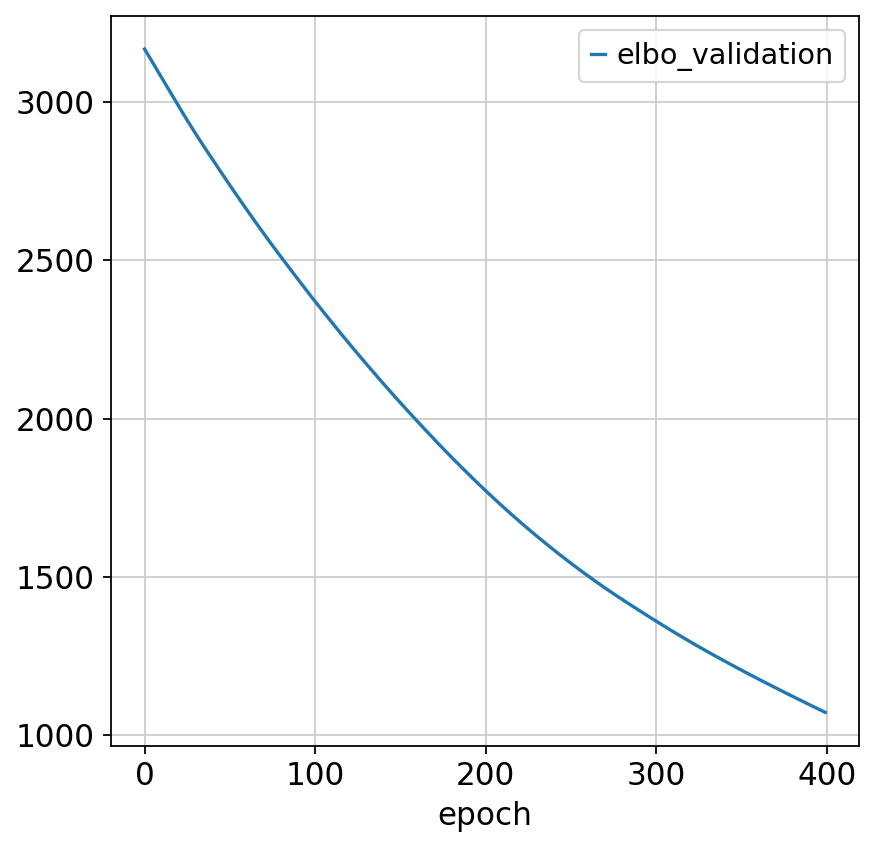

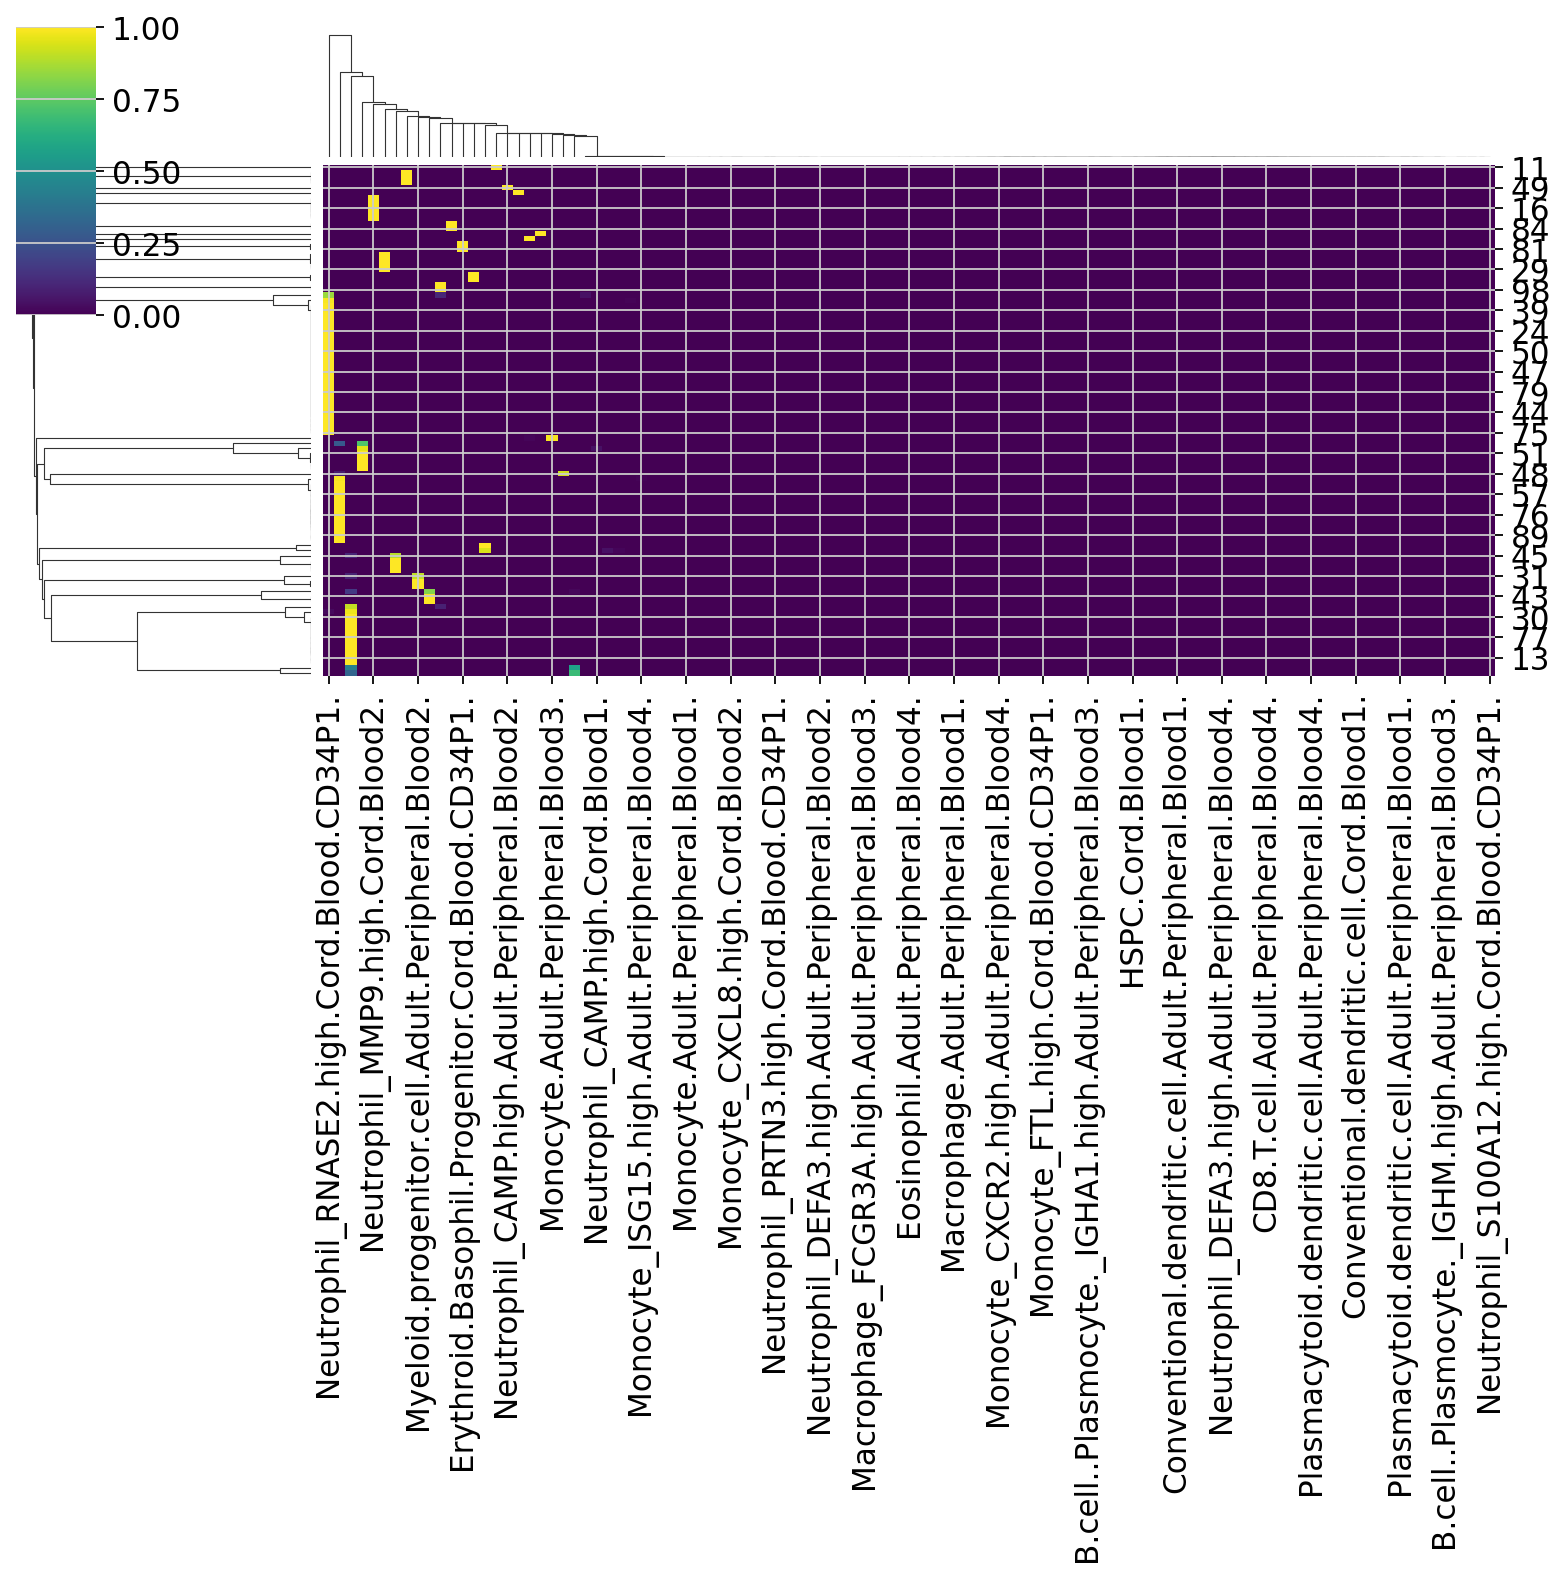

In [32]:
# Getting a stable counts layer to be used later, setting X to be raw count values. 
if COUNTS_LAYER == "X":
    adata.layers["counts"] = adata.X.copy()
    COUNTS_LAYER = "counts"
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER].copy()
else:
    raise ValueError(
        "{COUNTS_LAYER} layer can't be found in the object"
    )


# if ANNOTATION_METHOD == "scvi_cellassign":
#     markers = convert_scHCA(TISSUE)
#     model, adata_annotated = scvi_cellassign_annotate(adata, markers, subsample=100)
#     model.train(batch_size = 8192, max_epochs=400)

#     model.history["elbo_validation"].plot()

#     predictions = model.predict()
#     predictions.head()

#     sns.clustermap(predictions, cmap="viridis")
#     adata_annotated.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values


if ANNOTATION_METHOD == "celltypist":
    cell_typist_annotate(adata, CELL_TYPIST_MODELS)